# Implementing Decision Trees from Scratch

Task:

We are given a dataset of variuos `url`s, with columns `url` and `type` where type being the binary target column. We have to develop a `Decision Tree` that can differentiate if a given `url` is `benign` or `defacement`.

The data preprocessing steps are same as of previous lab. 

This notebook focuses on the implementation of `DecisionTree` class for categorical data as of now. 

```

## Imports

In [36]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

## Data Preprocessing and Feature Engineering

In [37]:
# Load the dataset as pandas dataframe
dataset_path = "./benign_vs_defacement_urls.csv"
df = pd.read_csv(dataset_path, encoding = "ISO-8859-1", on_bad_lines='warn')

df.head()

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_37732\3312718202.py:3: ParserWarning: Skipping line 463992: expected 2 fields, saw 3
Skipping line 502270: expected 2 fields, saw 3
Skipping line 517723: expected 2 fields, saw 3

  df = pd.read_csv(dataset_path, encoding = "ISO-8859-1", on_bad_lines='warn')


,url,type
0,mp3raid.com/music/krizz_kaliko.html,benign
1,bopsecrets.org/rexroth/cr/1.htm,benign
2,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
3,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
4,yourbittorrent.com/?q=anthony-hamilton-soulife,benign


In [38]:
# Malicious keywords
keywords = ['win', 'gold', 'bet', 'lottery', 'rummy', 'play', 'game', 'gov', 'money', 'crypto', 'trade']

for keyword in keywords:
    df[keyword] = df['url'].str.count(keyword)

# Check for shortened URL
shortened_url_expression = r"(bit\.ly|tinyurl\.com|t\.co|rebrand\.ly|goo\.gl|ow\.ly|is\.gd|buff\.ly|adf\.ly|bit\.do|mcaf\.ee|su\.pr|v\.gd|tiny\.cc|shorte\.st|linksynergy\.com)"
df['is_shortened'] = df['url'].str.contains(shortened_url_expression)

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_37732\2758516492.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_shortened'] = df['url'].str.contains(shortened_url_expression)


In [39]:
# Extracting other information
df['domain_extension'] = df['url'].str.extract(r'\.([a-z]{2,}(?:\.[a-z]{2,})?)(?:[/?#]|$)')
df['end_file_extension'] = df['url'].str.extract(r'\.([a-z]{2,})$')
df['digit_count'] = df['url'].str.count('[0-9]')
df['symbol_count'] = df['url'].str.count('[^0-9a-zA-z]')
df['alphabet_count'] = df['url'].str.count('[a-zA-z]')
df['http_count'] = df['url'].str.count('http')

In [40]:
target_feature = 'type'

df.head()

,url,type,win,gold,bet,lottery,rummy,play,game,gov,money,crypto,trade,is_shortened,domain_extension,end_file_extension,digit_count,symbol_count,alphabet_count,http_count
0,mp3raid.com/music/krizz_kaliko.html,benign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,com,html,1.0,4.0,30.0,0.0
1,bopsecrets.org/rexroth/cr/1.htm,benign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,org,htm,1.0,5.0,25.0,0.0
2,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,net,html,1.0,24.0,93.0,1.0
3,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False,go.com,NaN,4.0,9.0,32.0,0.0
4,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,com,NaN,0.0,6.0,40.0,0.0


In [41]:
print("Null value count in the dataset: ")
print(df.isnull().sum())

Null value count in the dataset: 
url                        8
type                      61
win                        8
gold                       8
bet                        8
lottery                    8
rummy                      8
play                       8
game                       8
gov                        8
money                      8
crypto                     8
trade                      8
is_shortened               8
domain_extension         180
end_file_extension    386725
digit_count                8
symbol_count               8
alphabet_count             8
http_count                 8
dtype: int64


In [42]:
# Too much missing data in `end_file_extension` column
df['end_file_extension'] = df['end_file_extension'].fillna('none')
df['domain_extension'] = df['domain_extension'].fillna('none')

# Drop missing values
print("Before dropping, the shape of the dataset is:")
print(df.shape)
df = df.dropna()
print("After dropping null values, the shape of the dataset is:")
print(df.shape)

# Convert categorical data to numerical data
df['domain_extension'] = df['domain_extension'].astype('category').cat.codes
df['end_file_extension'] = df['end_file_extension'].astype('category').cat.codes
df['is_shortened'] = df['is_shortened'].astype('category').cat.codes

df = df.drop(columns=['url'])
df['type'] = df['type'].map({"benign": 0, "defacement": 1})


Before dropping, the shape of the dataset is:
(524618, 20)
After dropping null values, the shape of the dataset is:
(524549, 20)


In [43]:
df[target_feature].value_counts()

type
0    428103
1     96446
Name: count, dtype: int64

In the output of the above cell we can see that the dataset contains more `benign` sample points. So, we have to resample our training data. It's is not required to upsample the test data as well.

**Why splitting first and then doing upsamping?**
- If we do the other way, there are very high chances of **data leakage**. Meaning that some samples will be there in both the training data and the testing data.


> Although, Decision Trees **do not require upsampling** of the (training) data, but it's good practice to do so when we will have deal with models like Regression and Neural Networks. 

In [44]:
# Split dataset before up sampling to prevent data leakage. 
train_data, test_data = train_test_split(
    df, 
    test_size=0.2,
    stratify=df[target_feature],
    random_state=42
)
print(f"Original train_data shape = {train_data.shape}")

# Upsample only the train dataset
train_majority = train_data[train_data[target_feature] == 0]
train_minority = train_data[train_data[target_feature] == 1]

train_minority_upsampled = resample(
    train_minority, 
    replace=True,
    n_samples=len(train_majority),
    random_state=42
)

train_data = pd.concat([train_majority, train_minority_upsampled])


# We will keep the test data as it is. (naturally imbalanced is fine for testing)
y_test = test_data[target_feature]
test_data = test_data.drop(columns=[target_feature])

print(f"Upsampled train_data shape = {train_data.shape}")
print(f"test_data shape = {test_data.shape}")

Original train_data shape = (419639, 19)
Upsampled train_data shape = (684964, 19)
test_data shape = (104910, 18)


## Implementation from Scratch

### `DecisionTree` class design:

- `Node` class:
    - `feature_name: str`: name of the splitting feature on the node.
    - `categories`: a dictionary having category to node mappings.
    - `is_leaf: bool`: `True` if the node is a leaf node.
    - `result`: in case if a node is a leaf node, we can return the most dominating value in the subtree. 

- Instance Attributes:
    - `nodes: List[Node]`: list of nodes in the decision tree.
    - `target_feature: str`: target feature that needs to be predicted.
    - `features: List[str]`: features in the dataset other than the `target_feature`.

- Public Methods:
    - `fit(df: pd.DataFrame, target_feature: str)`: method to fit the training data.
    - `predict(df: pd.DataFrame)`: predicts for the test data. 

- Private Methods:
    - `entropy(df: pd.DataFrame, target_feature: str)`: calculates entropy of a `df` object when target is the `target_feature`.
    - `information_gain(df: pd.DataFrame, splitting_feature: str, target_feature: str)`: calculates the information gain if splitted by the `splitting_feature` and when target is the `target_feature`.
    - `get_dominating_class(df: pd.DataFrame)`: finds the dominating class in `target_feature` column of the dataset.
    - `build_tree(df: pd.DataFrame, node_ind: int)`: recursively builds the decision tree by greedily maximizing the information gain at each step. 
    - `predict_one(row: pd.Series)`: predict the `target_feature` for one row at a time.


In [ ]:
class DecisionTree:
    class Node:
        def __init__(self, feature_name: str="", is_leaf=False):
            self.feature_name = feature_name
            self.categories = {}
            self.is_leaf = is_leaf
            self.result = -1

    def __init__(self):
        self.nodes = [self.Node("root")]
        self.target_feature = ""
        self.features = []

    def entropy(self, df: pd.DataFrame, target_feature: str): 
        if target_feature not in df.columns:
            print("ERROR: target feature {target_feature} not found in the provided DataFrame object columns.")
            return -1

        categories = df[target_feature].unique().tolist()
        frequencies = df[target_feature].value_counts().reindex(categories, fill_value=0).tolist()
        frequencies = [(f / len(df)) * math.log2(f / len(df)) if f != 0 else 0 for f in frequencies]
        result = -sum(frequencies)
        
        return result
    
    def gini_impurity(self, df: pd.DataFrame, target_feature: str): 
        # Calculating Gini Impurity is a little bit computationally cheaper than calculating Entropy because of the logarithm.
        if target_feature not in df.columns:
            print("ERROR: target feature {target_feature} not found in the provided DataFrame object columns.")
            return -1

        categories = df[target_feature].unique().tolist()
        frequencies = df[target_feature].value_counts().reindex(categories, fill_value=0).tolist()
        frequencies = [(f / len(df))**2 if f != 0 else 0 for f in frequencies]
        result = 1 - sum(frequencies)

        return result

    def information_gain(self, df: pd.DataFrame, splitting_feature: str, target_feature: str, method: str='entropy'):
        num_samples = len(df)
        root_entropy = self.entropy(df, target_feature) if method == 'entropy' else self.gini_impurity(df, target_feature)
        weighted_split_entropy = 0
        categories = df[splitting_feature].unique().tolist()

        for category in categories:
            temp = df[df[splitting_feature] == category]
            split_entropy = self.entropy(temp, target_feature) if method == 'entropy' else self.gini_impurity(temp, target_feature)
            weighted_split_entropy += len(temp) * split_entropy
        
        weighted_split_entropy = weighted_split_entropy / num_samples
        return root_entropy - weighted_split_entropy
    
    def get_dominating_class(self, df: pd.DataFrame):
        return df[self.target_feature].value_counts().idxmax()
    
    def build_tree(self, df: pd.DataFrame, node_ind: int):
        if df[self.target_feature].nunique() <= 1:
            self.nodes[node_ind].is_leaf = True
            self.nodes[node_ind].result = int(df.iloc[0][self.target_feature])
            return
            
        information_gains = [self.information_gain(df, feature_name, self.target_feature) for feature_name in self.features]
        best_splitting_feature = ""
        best_info_gain = 0

        for splitting_feature, info_gain in zip(self.features, information_gains):
            if info_gain > best_info_gain:
                best_info_gain = info_gain 
                best_splitting_feature = splitting_feature
        
        if best_info_gain == 0 or len(set(information_gains)) <= 1:
            self.nodes[node_ind].is_leaf = True
            self.nodes[node_ind].result = int(self.get_dominating_class(df))
            return
        
        self.nodes[node_ind].feature_name = best_splitting_feature
        categories = df[best_splitting_feature].unique()

        for category in categories:
            self.nodes[node_ind].categories[category] = len(self.nodes)
            self.nodes.append(self.Node())
            self.build_tree(df[df[best_splitting_feature] == category], self.nodes[node_ind].categories[category])

    def fit(self, df: pd.DataFrame, target_feature: str):
        self.target_feature = target_feature
        self.features = df.columns.to_list()
        self.features.remove(self.target_feature)
        self.build_tree(df, 0)
    
    def predict_one(self, row: pd.Series):
        curr_idx = 0

        while self.nodes[curr_idx].is_leaf == False:
            if row[self.nodes[curr_idx].feature_name] in self.nodes[curr_idx].categories.keys():
                curr_idx = self.nodes[curr_idx].categories.get(row[self.nodes[curr_idx].feature_name])
            else:
                # There certainly exists a better way to handle this
                return 0
        
        return self.nodes[curr_idx].result
    
    def predict(self, df: pd.DataFrame):
        test_features = set(df.columns)
        if len(test_features.symmetric_difference(set(self.features))) != 0:
            print('Found different features in the training and testing dataset.')
            return None
        
        predictions = [self.predict_one(df.iloc[i]) for i in range(len(df))]
        return pd.Series(predictions)

## Train and Test

In [46]:
# Training
model = DecisionTree()
model.fit(train_data, target_feature)

Accuracy: 0.9862644171194357


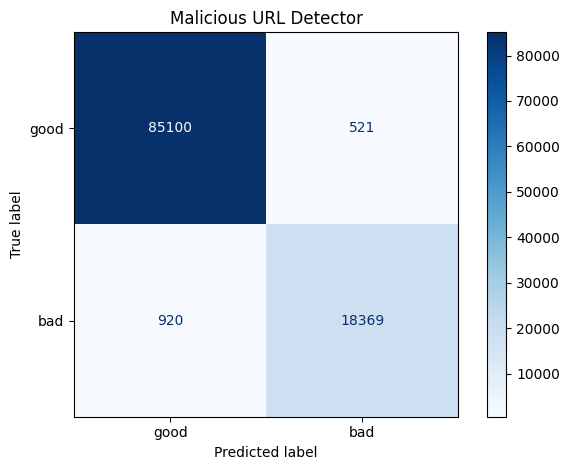

In [47]:
y_pred = model.predict(test_data)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['good', 'bad'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Malicious URL Detector")
plt.tight_layout()
plt.show()

### Test for Data Leakage

In [48]:
# Check for duplicate rows between train and test
train_indices = set(train_data.index)
test_indices = set(test_data.index)
overlapping_indices = train_indices.intersection(test_indices)

print(f"Number of overlapping indices between train and test: {len(overlapping_indices)}")

# Alternative: Check if actual rows are duplicated
duplicates = train_data.reset_index(drop=True).isin(test_data.reset_index(drop=True)).all(axis=1).sum()
print(f"Number of duplicate rows (by value): {duplicates}")


Number of overlapping indices between train and test: 0
Number of duplicate rows (by value): 0
